In [1]:
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
import pytz
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import pearsonr
from scipy.stats import linregress
import numpy as np
import string

tz = pytz.timezone('Europe/Madrid')

In [2]:
API_URL = "https://flowmaps.life.bsc.es/api"


def fetch_all_pages(collection, query={}, batch_size=1000, projection={}):
    base_url = API_URL
    url = f"{base_url}/{collection}"
    params = {'where': json.dumps(query), 'max_results': batch_size, 'projection': json.dumps(projection)}
    data = []
    response = requests.get(url, params=params).json() # get first page
    data.extend(response['_items'])
    if '_links' not in response:
        return data
    num_docs = response['_meta']['total']
    if num_docs <= 0:
        return data
    while 'next' in response['_links']:
        url = f"{base_url}/{response['_links']['next']['href']}"
        response = requests.get(url).json()
        data.extend(response['_items'])
    return data


def get_ids_layer(layer):
    docs = fetch_all_pages('layers', {'layer': layer}, projection={'id': 1})
    return sorted([doc['id'] for doc in docs])


def get_date(date_strn):
    date = datetime.strptime(date_strn, '%Y-%m-%d')
    start_summer_time = datetime(date.year, 3, 29) # Spanish summer time
    end_summer_time = datetime(date.year, 10, 25)
    if start_summer_time <= date <= end_summer_time:
        delta_h = timedelta(hours=2)
    else:
        delta_h =  timedelta(hours=1)
    date -= delta_h
    return date


def date_rfc1123(date_strn):
    """Return a string representation of a date according to RFC 1123
    (HTTP/1.1).

    The supplied date must be in UTC.

    """
    dt = get_date(date_strn)
    weekday = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"][dt.weekday()]
    month = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep",
             "Oct", "Nov", "Dec"][dt.month - 1]
    return "%s, %02d %s %04d %02d:%02d:%02d GMT" % (weekday, dt.day, month,
        dt.year, dt.hour, dt.minute, dt.second)


def get_overlaps(layerl, layerm, collection='layers.overlaps'):
    docs = fetch_all_pages(collection, {'l.layer': layerl, 'm.layer': layerm})
    flatten_docs = []
    for doc in docs:
        d = {}
        d['l_layer'] = doc['l']['layer']
        d['m_layer'] = doc['m']['layer']
        d['l_ratio'] = doc['l']['ratio']
        d['m_ratio'] = doc['m']['ratio']
        d['l_id'] = doc['l']['id']
        d['m_id'] = doc['m']['id']
        flatten_docs.append(d)
    return flatten_docs


def RMSE(x, y):
    return np.sqrt(((x - y) ** 2).mean())

In [3]:
# get ids of the two layers
municip_ids = get_ids_layer('cnig_municipios')
mitma_ids = get_ids_layer('mitma_mov')

In [4]:
# get census population from cnig dataset
df_cnig_pop = pd.DataFrame(fetch_all_pages('cnig.municipios'))
df_cnig_pop['id'] = df_cnig_pop['cod_ine'].apply(lambda x: x[:5])
columns = ['id', 'cod_ine', 'poblacion_muni', 'nombre_actual', 'cod_prov', 'provincia']
df_cnig_pop = df_cnig_pop[columns]
cnig_pop = df_cnig_pop.set_index('id')['poblacion_muni'].to_dict()

In [5]:
# get estimated population from mitma mobility dataset
df = pd.DataFrame(fetch_all_pages('mitma_mov.zone_movements', {'evstart': date_rfc1123('2020-02-15')}))
pop = df.groupby('id')['personas'].sum().to_dict()
df_mitma_pop = pd.DataFrame([{'id': _id, 'pop': pop.get(_id, 0)} for _id in mitma_ids])

In [6]:
# get area overlaps and population overlaps between the two layers 
overlaps_mitma_muni_area = pd.DataFrame(get_overlaps('mitma_mov', 'cnig_municipios', 'layers.overlaps'))
overlaps_mitma_muni_grid = pd.DataFrame(get_overlaps('cnig_municipios', 'mitma_mov', 'layers.overlaps_population'))

In [7]:
# project population using area overlaps  
df_proj_area = df_mitma_pop.merge(overlaps_mitma_muni_area, left_on='id', right_on='l_id')
df_proj_area['proj_pop'] = df_proj_area['pop'] * df_proj_area['l_ratio']
pop_from_area_overlaps = df_proj_area.groupby('m_id')['proj_pop'].sum().to_dict()

In [8]:
# project population using population grid overlaps  
df_proj_grid = df_mitma_pop.merge(overlaps_mitma_muni_grid, left_on='id', right_on='m_id')
df_proj_grid['proj_pop'] = df_proj_grid['pop'] * df_proj_grid['m_ratio']
pop_from_grid_overlaps = df_proj_grid.groupby('l_id')['proj_pop'].sum().to_dict()

In [9]:
# joint dataframe
df_population = pd.DataFrame({'muni_id': municip_ids})
df_population['pop_from_CNIG'] = df_population['muni_id'].apply(cnig_pop.get)
df_population['pop_from_MITMA_area_overlaps'] = df_population['muni_id'].apply(pop_from_area_overlaps.get)
df_population['pop_from_MITMA_grid_overlaps'] = df_population['muni_id'].apply(pop_from_grid_overlaps.get)
df_population = df_population.dropna()
df_population

,muni_id,pop_from_CNIG,pop_from_MITMA_area_overlaps,pop_from_MITMA_grid_overlaps
0,01001,2876.0,449.544993,3274.091133
1,01002,10350.0,10025.859942,10173.418283
2,01003,1467.0,1963.216691,1650.876373
3,01004,1821.0,879.007452,1990.102523
4,01006,227.0,176.330347,345.686919
...,...,...,...,...
8126,50901,154.0,466.429303,169.736283
8127,50902,86.0,60.001148,111.453343
8128,50903,2720.0,1685.915929,2860.648741
8129,51001,84777.0,66609.815578,74888.763501


Resiudals 1240.31474100678
R-squared: 0.999050
237.97029915818075 0.9400817139301004
1.00  0.00E+00  3163.23
Resiudals 858.3661785640077
R-squared: 0.999603
202.7138202473825 0.9482964975345795
1.00  0.00E+00  2616.32


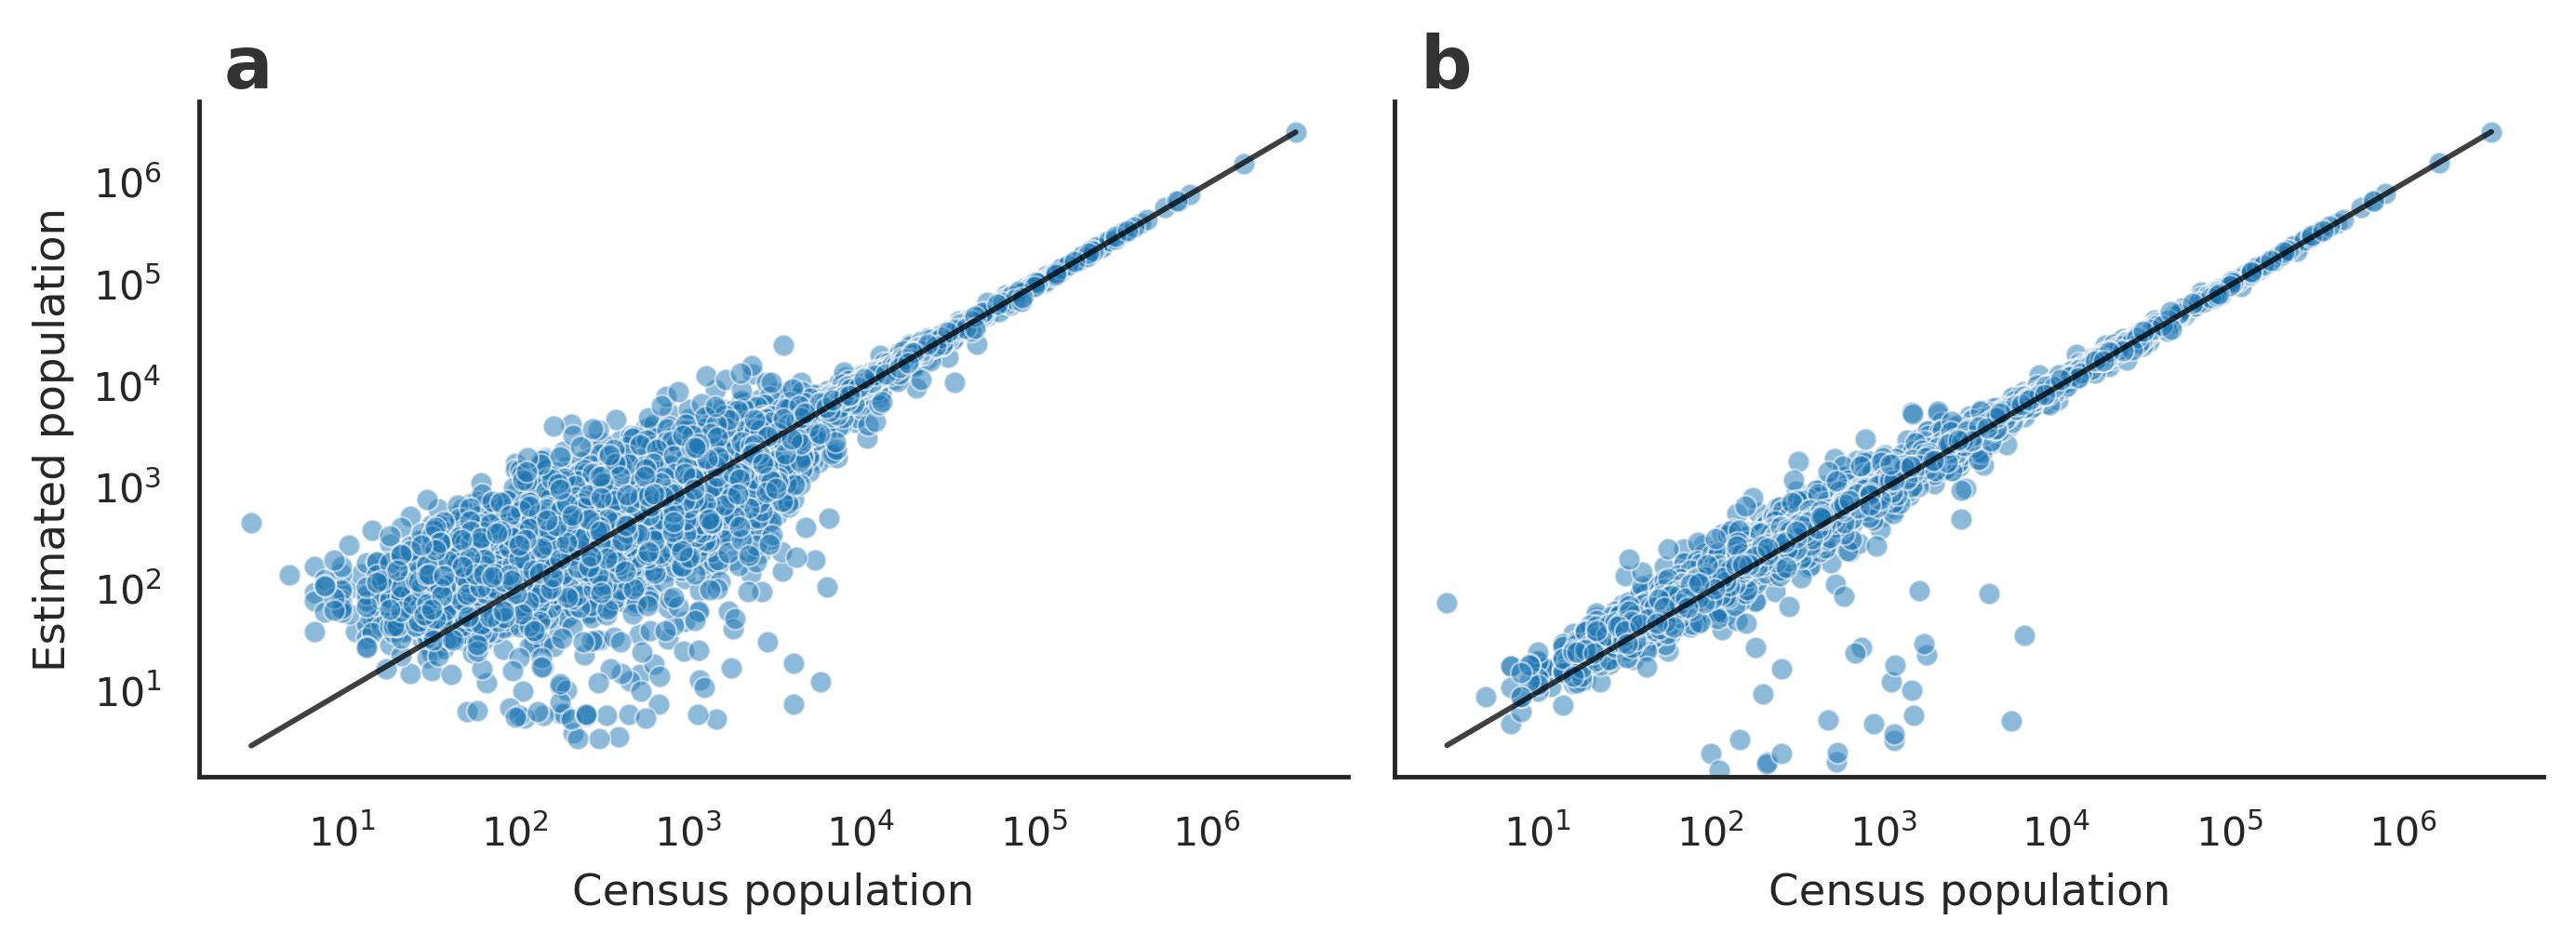

In [10]:
sns.set_style('white')
sns.set_context('paper')

fig, axes = plt.subplots(1,2, figsize=(8,3), dpi=350, sharex=True, sharey=True)
for i, k in enumerate(['pop_from_MITMA_area_overlaps', 'pop_from_MITMA_grid_overlaps']):
    
    X = df_population['pop_from_CNIG'].values
    y = df_population[k].valuespop_from_MITMA_area_overlaps
    
   
    r, p = pearsonr(X, y)
    res = linregress(X, y)
    y_predicted = X * res.slope
    residuals = np.abs(y-y_predicted)
    rmse = RMSE(df_population['pop_from_CNIG'], df_population[k])
    
    print("Resiudals", np.std(residuals))
    print(f"R-squared: {res.rvalue**2:.6f}")
    print(res.intercept, res.slope)
    print("%.2f  %.2E  %.2f" % (r, p, rmse))

    ax = axes[i]
    ax.scatter(X, y, alpha=0.5, edgecolor='w', linewidth=0.5)
    ax.plot(sorted(X), sorted(y_predicted), c='k', alpha=0.75)
    ax.set(xscale="log", yscale="log")
    ax.set_xlabel('Census population')
    ax.text(0.022, 1.02, string.ascii_lowercase[i], fontsize=16, 
            transform=ax.transAxes, weight='bold', color='#333333')
    if i == 0:
        ax.set_ylabel('Estimated population')
    

fig.tight_layout()
sns.despine(fig)